## Chapter 3 : Labeling

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import itertools as it 

### SNIPPET 3.1 Daily Volaitility Estimates<a name='s_3_1'></a>
+ compute the daility volatility at intraday estimation points
+ apply a sapn of ```span0``` days to an EWMstd
+ see [pandas.Series.ewm](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.ewm.html)

```python
def getDailityVol (close, span0 = 100):
    # daily vol, redindexed to close
    df0.close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0>0]
    df0 = pd.Series(close.index[df0-1], index=close.index[close.shape[0],df0.shape[0],:])
    df0 = close.loc[df0.index]/close.loc[df0.values].values-1 # dailiy returns
    df0 = df0.ewm(sapn = span0).std()
    return df0
```
    

In [55]:
def getDailityVol (
    df,
    col_close='close',
    col_dVol='dVol',
    span0 = 100
    ):
    df[col_dVol]=df[col_close].pct_change()
    df[col_dVol] = df[col_dVol].ewm(span=100).std()

In [56]:
df = pd.read_csv('dollar_D_15.csv',index_col='timestamp')
getDailityVol(df,col_close='price')

#df['price'].index.searchsorted(df.index - pd.Timedelta(days=1))

### SNIPPET 3.4 ADDING A VERTICAL BARRIER<a name='s_3_4'></a>

```python
t1 = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
t1 = t1[t1< close.shape[0]]
t1= pd.Series(close.index[t1],index=tEvents[:t1.shape[0]])# NaNs at end
```

## Form Dollar bars for E-mini S&P 500 futures -> test.csv

## EXERCISES 3.1.a<a name='e_3_1_a'></a>
Apply a symmetric CUSUM filter, where the thrshold is the standard deviation of dailty returns - [snippet 3.1](#s_3_1)

In [6]:
df3_1 = pd.read_csv('dollar_D_15.csv',index_col='timestamp')
df3_1.head()

,price
timestamp,
2018-11-21 09:02:00,266.149994
2018-11-21 09:06:00,266.100006
2018-11-21 09:11:00,266.200012
2018-11-21 09:19:00,266.350006
2018-11-21 09:33:00,266.100006


In [29]:
def npMovingAverage(data, window=3):
    weights = np.ones(window) / window
    return np.convolve(data, weights, mode='valid')

def getDailityVol (
    df,
    col_close='close',
    col_dVol='dVol',
    span0 = 100
    ):
    df[col_dVol]=df[col_close].pct_change()
    df[col_dVol] = df[col_dVol].ewm(span=100).std()
    return df[col_dVol]
def CUSUM_4(
    df,
    col='close',
    window=20,
    h=0.05
   ):
    bar = df.drop(df.columns.difference([col]), axis=1)
    tmp = np.log(bar[col]).diff().fillna(0)
        
    ma = npMovingAverage(tmp,window)      
    tmp = tmp[window-1:]
    tmp = tmp - ma    

    tmp_p = list(it.accumulate(tmp, lambda x, y: max(x+y, 0) if (x+y) >= h else 0))
    tmp_n = list(it.accumulate(tmp, lambda x, y: min(x+y, 0) if (x+y) <= -h else 0))
    
    s1 = [index for index, value in enumerate(tmp_p) if value !=0]
    s2 = [index for index, value in enumerate(tmp_n) if value !=0]
        
    s_p = bar.iloc[s1]
    s_n = bar.iloc[s2]    
    
    s_t = pd.concat([s_p,s_n],axis = 1,sort=True)
    s_t.columns = ['s_p','s_n']
    
    s_t['s_t'] = s_t.apply(lambda x: x['s_n'] if pd.isna(x['s_p']) else x['s_p'],axis=1)
    
    return s_t

def CUSUM_dVol(
    df,
    col='close',
    window=20,
    h=0.05
   ):
    bar = df.drop(df.columns.difference([col]), axis=1)
    tmp = np.log(bar[col]).diff().fillna(0)
        
    ma = npMovingAverage(tmp,window)      
    tmp = tmp[window-1:]
    tmp = tmp - ma    
    
    dVol = getDailityVol(df,col_close='price')
    tmp_p = tmp - dVol
    tmp_n = tmp + dVol
    tmp_p = list(it.accumulate(tmp_p, lambda x, y: max(x+y, 0) if (x+y) >= 0 else 0))
    tmp_n = list(it.accumulate(tmp_n, lambda x, y: min(x+y, 0) if (x+y) <= 0 else 0))
    
    s1 = [index for index, value in enumerate(tmp_p) if value !=0]
    s2 = [index for index, value in enumerate(tmp_n) if value !=0]
        
    s_p = bar.iloc[s1]
    s_n = bar.iloc[s2]    
    
    s_t = pd.concat([s_p,s_n],axis = 1,sort=True)
    s_t.columns = ['s_p','s_n']
    
    s_t['s_t'] = s_t.apply(lambda x: x['s_n'] if pd.isna(x['s_p']) else x['s_p'],axis=1)
    
    return s_t

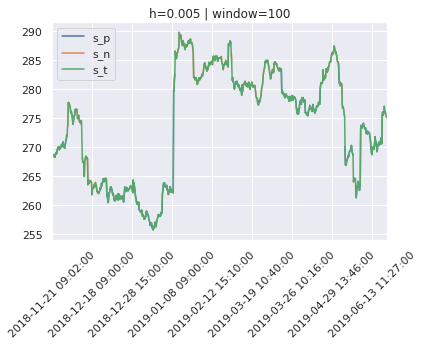

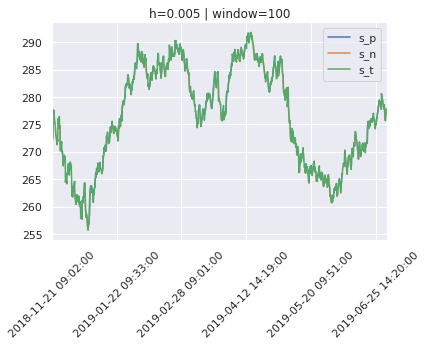

In [36]:
h_t = 0.005

window=100
#s_t = CUSUM3('dollar_t5300000_d200.csv',h=h_t,window=window)
df = pd.read_csv('dollar_D_15.csv',index_col='timestamp')
s_t_1= CUSUM_4(df,h=h_t,window=window,col='price')
s_t_2 = CUSUM_dVol(df,h=h_t,window=window,col='price')


#getDailityVol(df,col_close='price')
s_t_1.plot(
    use_index =True,
    subplots=False,
    sharex =True,
    rot =45,
   # figsize=(20,10),
    title='h=' + str(h_t) + ' | window='+str(window)
)
s_t_2.plot(
    use_index =True,
    subplots=False,
    sharex =True,
    rot =45,
   # figsize=(20,10),
    title='h=' + str(h_t) + ' | window='+str(window)
)

## EXERCISES 3.1.b<a name='e_3_1_b'></a>
Use Snippet 3.4 on a pandas series ```t1```, where ```numDays = 1```

## EXERCISES 3.1.c<a name='e_3_1_c'></a>
On those samped features, applay the triple-barrier method, where ```psS1=[1,1]``` and ```t1``` is the series you crated in point 1.b

## EXERCISES 3.1.d<a name='e_3_1_d'></a>
Applay ```getBins``` to generate lables